# Tutorial - Wind Power Prediction Using Gaussian Processes

***Machine Learning for Renewable Energy Systems***

**Timo Lübbing**

**University of Tübingen**

#### Introduction

This tutorial explores the application of Gaussian Processes (GP) in forecasting wind power generation. Through a series of code examples and explanations, you'll gain insights into data preprocessing, feature engineering, and the training and evaluation of GP models for wind energy prediction.

Additionally, we'll examine how different weather input features influence the model's performance.

#### The Data

We have access to the realised energy supply for various energy sources in germany, including on and offshore wind production. In addition, we have access to numerical weather data. Both datasets contain time series data with a 15-minute resolution, covering the perio from 2019 to to 2023. 

#### Preprocessing

Lets get started by loading the data and looking at it.

In [1]:
import sys
import pandas as pd
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import properscoring as ps

from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LassoCV
from torch.utils.data import DataLoader, TensorDataset

sys.path.append(str(Path("..").resolve()))
from src.visualizations import (
    setup_tueplots,
    plot_wind_power_composition,
    plot_wind_speed_components,
)
from src.preprocessing import (
    Column,
    preprocess_supply_data,
    weather_germany_mean,
    weather_germany_clustered,
    create_time_features,
    create_sliding_window_data,
)
from src.checkpoint import save_checkpoint, load_checkpoint

**Load the Energy Supply Data**

In [2]:
path = Path('..') / 'data' / 'Realised_Supply_Germany.csv'
df = pd.read_csv(path, sep=';', decimal=',')
df.head(2)

,Date from,Date to,Biomass [MW],Hydro Power [MW],Wind Offshore [MW],Wind Onshore [MW],Solar Power [MW],Other Renewable [MW],Nuclear Power [MW],Lignite [MW],Coal [MW],Natural Gas [MW],Pumped Storage [MW],Other Conventional [MW]
0,01.01.19 00:00,01.01.19 00:15,"1.199,00",401.00,"794,25","4.839,25",0,31.5,"2.250,50","1.733,00","836,25","850,5","87,5",431.75
1,01.01.19 00:15,01.01.19 00:30,"1.203,00",394.75,"793,5","5.030,75",0,31.5,"2.263,25","1.587,75","729,5","821,5","99,25",429.75


Proprocessing steps for the energy supply data include:
- Convert to datetime index
- Resample 15-minute intervals to hourly data
- Convert non-numeric columns to float type
- Add a column for the sum of on and offshore wind production. This will be our target variable for the model.

In [3]:
df = preprocess_supply_data(df, resample="h")
df.head(2)

,Biomass [MW],Hydro Power [MW],Wind Offshore [MW],Wind Onshore [MW],Solar Power [MW],Other Renewable [MW],Nuclear Power [MW],Lignite [MW],Coal [MW],Natural Gas [MW],Pumped Storage [MW],Other Conventional [MW],Wind Sum [MW]
Date from,,,,,,,,,,,,,
2019-01-01 00:00:00,4815.25,85420,3134.00,20391.75,0.0,1260,9001.50,6335.0,2811.75,3273.25,271.75,133590,23525.75
2019-01-01 01:00:00,4808.75,50480,2868.25,22365.50,0.0,1260,8535.25,5379.5,2404.25,2967.25,21.50,130290,25233.75


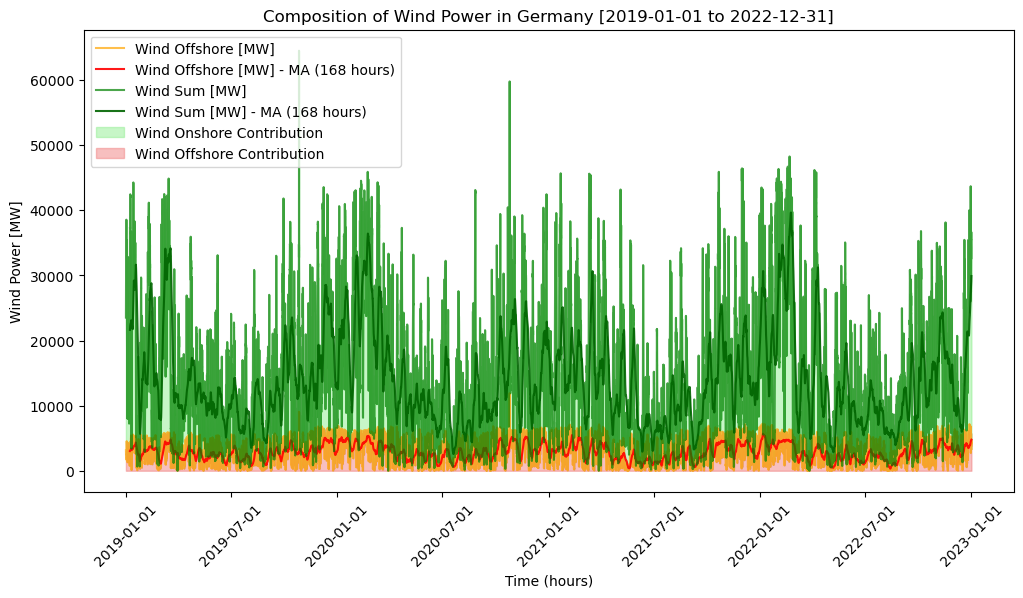

In [4]:
fig = plot_wind_power_composition(
    dates=df.index,
    wind_offshore=df[Column.WIND_OFFSHORE.value],
    wind_onshore=df[Column.WIND_ONSHORE.value],
    moving_average_window=24*7
)

**Wind Power Composition**

We can already see a clear seasonal pattern in the onshore wind production. The offshore wind production is more stable, but also shows some seasonal patterns. Overall, the total wind power production underlies strong noise.

The following code visulalizes the composition of just a single year:

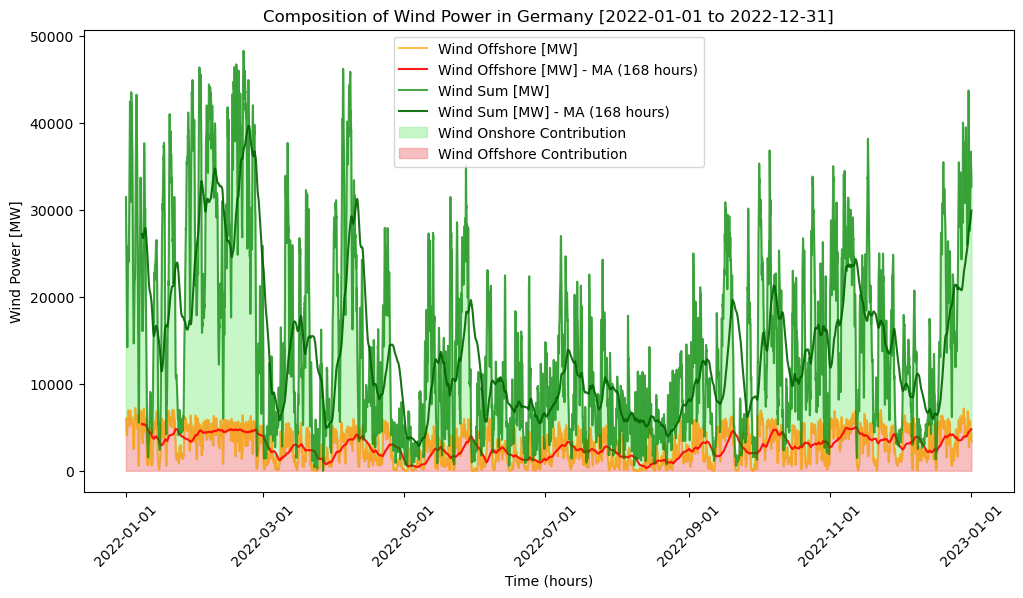

In [5]:
# df_indexed = df["2022-01-01":"2022-12-31"]
df_indexed = df["2022-01-01":"2022-12-31"]
wind_offshore_2022 = df_indexed[Column.WIND_OFFSHORE.value]
wind_onshore_2022 = df_indexed[Column.WIND_ONSHORE.value]
dates_2022 = df_indexed.index

fig = plot_wind_power_composition(
    dates_2022, wind_offshore_2022, wind_onshore_2022, 24*7,
)

**Target Sum of On and Offshore Wind Production**

The below plot shows the total wind power production in Germany for the year 2022. This time series is our target and the year we want to predict within the test set.

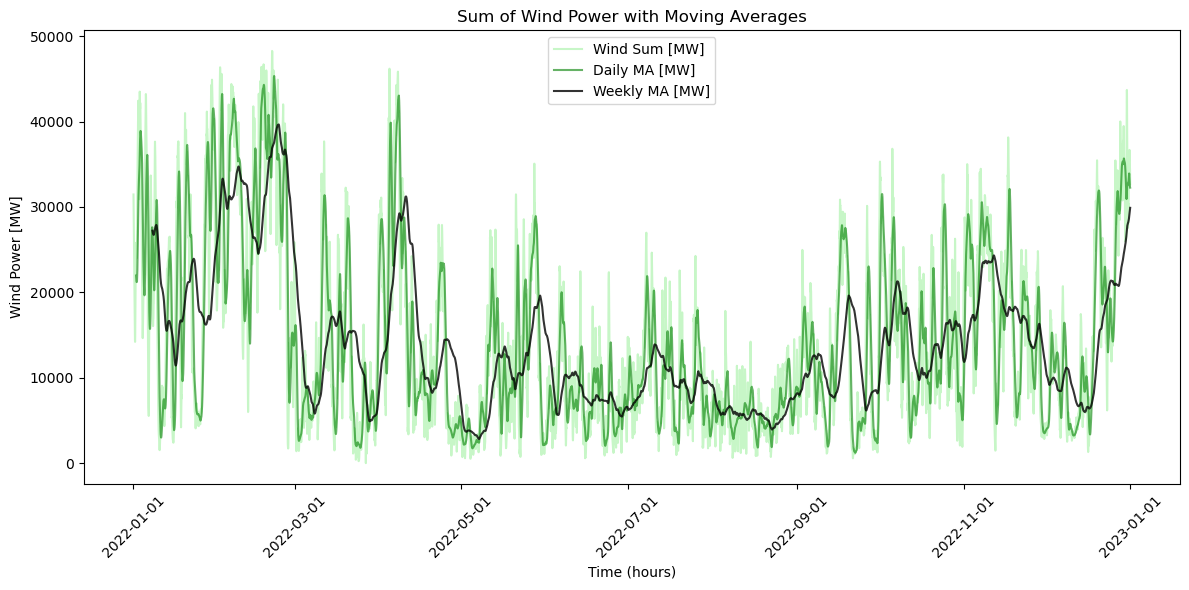

In [6]:
wind = df_indexed[Column.WIND.value]
dates = df_indexed.index

# Calculate moving averages
wind_daily_ma = wind.rolling(window=24).mean()
wind_weekly_ma = wind.rolling(window=24*7).mean()
wind_monthly_ma = wind.rolling(window=24*30).mean()

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
locator = ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator=locator))

ax.plot(dates, wind, label="Wind Sum [MW]", color="lightgreen", alpha=0.5)
ax.plot(dates, wind_daily_ma, label="Daily MA [MW]", color="green", alpha=0.6)
ax.plot(dates, wind_weekly_ma, label="Weekly MA [MW]", color="black", alpha=0.8)

ax.set_title("Sum of Wind Power with Moving Averages")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Wind Power [MW]")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Load the Weather Data**

In [7]:
weather_path = Path('..') / "data" / "Weather_Data_Germany.csv"
weather_2022_path = Path('..') / "data" / "Weather_Data_Germany_2022.csv"
weather = pd.read_csv(weather_path, sep=',', decimal='.')
weather_2022 = pd.read_csv(weather_2022_path, sep=',', decimal='.')

weather.head(2)

,longitude,latitude,forecast_origin,time,cdir,z,msl,blh,tcc,u10,v10,t2m,ssr,tsr,sund,tp,fsr,u100,v100
0,5.8,54.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-2.766602,102439.914,766.03015,0.304399,11.806978,2.823900,282.04110,0.0,0.0,0.0,0.0,0.000860,15.666069,3.153420
1,5.8,53.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-6.159180,102795.230,842.93190,0.945699,6.628730,1.767059,281.28223,0.0,0.0,0.0,0.0,0.254992,10.824787,2.401394


Preprocessing steps for the weather data include:
- Convert to datetime index
- Weather data is already in hourly resolution, so no resampling is needed
- Concatenate the disjoint yearly dataframes
- Average the weather data in germany over all weather stations recorded in the dataset.

In [8]:
def format_weather_time(weather: pd.DataFrame) -> None:
    """Formats weather data time column and sets it as index."""
    weather.drop(columns=["forecast_origin"], inplace=True)
    weather["time"] = pd.to_datetime(weather["time"], format="%Y-%m-%d %H:%M:%S")
    weather.set_index("time", inplace=True)
    weather.sort_index(inplace=True)

format_weather_time(weather)
format_weather_time(weather_2022)

weather = pd.concat([weather, weather_2022], axis=0)

In [9]:
# Select preprocessing method:
# 1. mean weather data across Germany
# 2. cluesterd mean weather data (keep parts of location information)

k_clusters = 5
use_clustering = False  # Default: False to reduce complexity

if use_clustering:
    weather = weather_germany_clustered(weather, k_clusters=k_clusters)
else:
    weather = weather_germany_mean(weather)

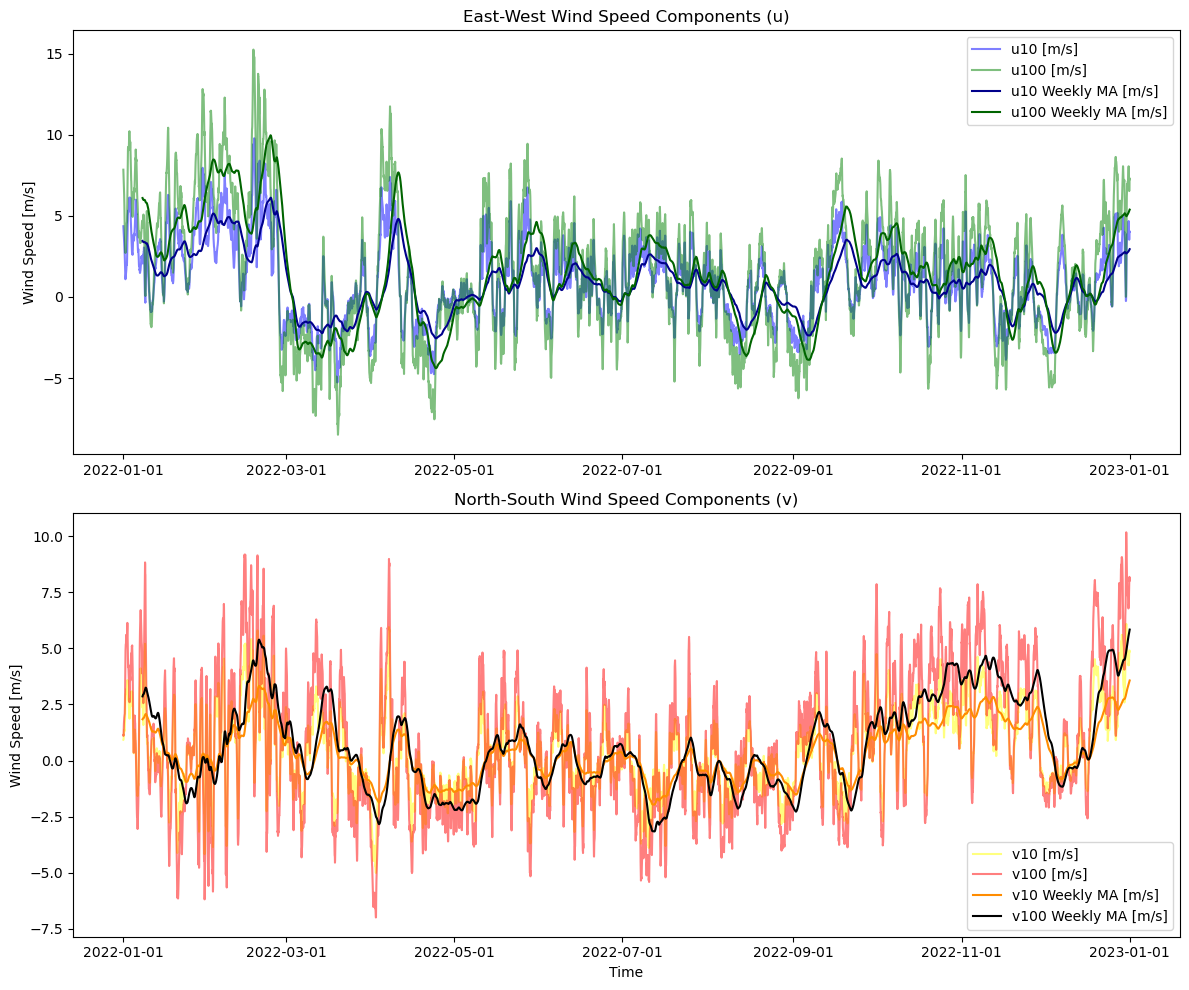

In [10]:
weather_indexed = weather["2022-01-01":"2022-12-31"]
plot_wind_speed_components(weather_indexed)

**Join the Dataframes**

In [11]:
# Join weather data with wind data
target = df[[Column.WIND.value]].copy()
dataframe = target.join(weather, how="inner")

### **Machine Learning Setup for Forecasting**

At this point in the tutorial we already loaded the given data, looked at the data and provided some basic preprocessing steps. Now, the time series data is aligned and ready for further processing and modeling in the machine learning setup. For time series forecasting, we will need to continue with the following steps to prepare the data for successful and efficient modeling and forecasting:

1. **Split data into training and testing sets**
   
   Carefully split the data in the time series context: Keep the `temporal order` intact and ensure that the training set prcedes the test set. This is crucial for time series forecasting to avoid data leakage and ensure that the model learns from past data to predict future values. 

2. **Feature engineering**
   
   - Create `time-based features` such as month of the year.
   - Use current weather data as `additional features`
   - Create `lagged features` to capture temporal dependencies in the data. (See sliding window approach below)
   - `Feature scaling`: Normalize or standardize the features to ensure that they are on a similar scale, which is particularly important for Gaussian Processes.
  
3. **Sliding window approach for time series forecasting**
   
   Implement a sliding window approach to create training samples. This involves defining a `window size` that determines how many past observations will be used to predict the next value. The window slides over the time series, creating training samples that consist of the past observations (lagged features), any additional features, and the target variable (the value to be predicted). We can further define the `forecast horizon` (hours) to predict ahead, which will determine how many future values we want to forecast based on the past observations. 
   
4. **Feature selection**
   After feature engineering, it's important to select relevant features that contribute significantly to the model's performance. This reduces complexity and significantly improves computational efficiency. The following methods can be used for feature selection:
   - Mutual Information, Pearson Correlation, Autocorrelation
   - Fit a Lasso regression model and select features based on coefficients (try LassoCV)

**Train and test set split**

Train years: 2019, 2020, 2021

Test year: 2022

In [12]:
# Train and test split
SPLIT_DATE = "2022-01-01"
START_DATE = df.index[0]
END_DATE = df.index[-1]

train_data = dataframe[START_DATE:SPLIT_DATE]
test_data = dataframe[SPLIT_DATE:END_DATE]

**Create Time Features**

Sine and cosine transformations of...
- the day of the week
- the month of the year
- the day of the year

In [13]:
# Create time features
train_data = create_time_features(train_data)
test_data = create_time_features(test_data)

**Standardize the target variable (Wind Sum [MW])**

Transform the target variable to have a mean of 0 and a standard deviation of 1. This is important for Gaussian Processes, as they assume that the target variable is normally distributed. The test data will be standardized using the mean and standard deviation of the training data.

In [14]:
# Scale target variable
target_scaler = StandardScaler()
train_data.loc[:, [Column.WIND.value]] = target_scaler.fit_transform(
    train_data.loc[:, [Column.WIND.value]]
)
test_data.loc[:, [Column.WIND.value]] = target_scaler.transform(
    test_data.loc[:, [Column.WIND.value]]
)

**Create Training and Test samples using a sliding window approach**

In [15]:
# Sliding window training
HISTORY_LENGTH = 24  # 24 hours (lag features)
FORECAST_HORIZON = 24  # 24 hours

X_df, y_df = create_sliding_window_data(
    data=train_data,
    history=HISTORY_LENGTH,
    forecast_horizon=FORECAST_HORIZON,
)
X_test_df, y_test_df = create_sliding_window_data(
    data=test_data,
    history=HISTORY_LENGTH,
    forecast_horizon=FORECAST_HORIZON,
)
print(X_df.columns)

Index(['lag_24', 'lag_23', 'lag_22', 'lag_21', 'lag_20', 'lag_19', 'lag_18',
       'lag_17', 'lag_16', 'lag_15', 'lag_14', 'lag_13', 'lag_12', 'lag_11',
       'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6', 'lag_5', 'lag_4', 'lag_3',
       'lag_2', 'lag_1', 'cdir', 'z', 'msl', 'blh', 'tcc', 'u10', 'v10', 't2m',
       'ssr', 'tsr', 'sund', 'tp', 'fsr', 'u100', 'v100', 'hour_sin',
       'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
       'dayofyear_sin', 'dayofyear_cos'],
      dtype='object')


In [16]:
lag_feature_names = [col for col in X_df.columns if col.startswith("lag_")]
time_feature_names = [col for col in X_df.columns if col.endswith("_sin") or col.endswith("_cos")]
weather_feature_names = list(set(X_df.columns) - set(lag_feature_names) - set(time_feature_names))

**Standardize the weather data**

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ("weather", StandardScaler(), weather_feature_names),
        ("time", "passthrough", time_feature_names),  # already scaled
        ("lag", "passthrough", lag_feature_names),  # already scaled with target variable
    ],
    remainder="drop",
)

In [18]:
X_np = preprocessor.fit_transform(X_df)
X_test_np = preprocessor.transform(X_test_df)
X_df = pd.DataFrame(X_np, columns=X_df.columns)
X_test_df = pd.DataFrame(X_test_np, columns=X_test_df.columns)

**Feature Selection**:

In [ ]:
# Feature selection methods
# (my intuition)
selected_lag_features = ["lag_1", "lag_3", "lag_6", "lag_12", "lag_18", "lag_24"]
selected_time_features = ["dayofyear_sin", "month_sin"]
selected_weather_features = ["u100", "v100", "t2m", "ssr"]

selected_features = selected_lag_features + selected_time_features + selected_weather_features
X_df = X_df[selected_features]
X_test_df = X_test_df[selected_features]

#### **Gaussian Process Forecasting**

Gaussian Processes (GP) are a powerful non-parametric Bayesian approach for regression tasks. An exact GP consists of mean and covariance functions that define the distribution over functions. The covariance function, also known as the kernel, captures the relationships between all data points in the input space. 

Thus, the resulting kernel matrix is of size `n x n`, where `n` is the number of training samples. This results in a computational complexity of O(n^3) for training, which can become intractable for large datasets. In addition, the kernel matrix is dense, leading to high memory consumption. 

In our wind power prediction task, we have a large number of training samples and high dimensional multivariate data, which makes exact Gaussian Processes impractical. We will use Approximate Gaussian Processes to handle the scalability issues.

**Approximate GPs**, particularly variational sparse GPs, offer a powerful and scalable way to apply Gaussian process models to larger datasets by using inducing points to create a low-rank approximation and optimizing a variational lower bound (ELBO) on the true marginal likelihood.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
# Transform data to torch tensors
float_precision = torch.float32

X = torch.tensor(X_df.values, dtype=float_precision, device=device)
y = torch.tensor(y_df.values, dtype=float_precision, device=device)
X_test = torch.tensor(X_test_df.values, dtype=float_precision, device=device)
y_test = torch.tensor(y_test_df.values, dtype=float_precision, device=device)
X.shape, y.shape, X_test.shape, y_test.shape

(torch.Size([26281, 16]),
 torch.Size([26281, 24]),
 torch.Size([8713, 16]),
 torch.Size([8713, 24]))

**Stochastic Variational Gaussian Processes (SVGP)**

Introducing Inducing Variables (Support Points): A small set of $M$ inducing variables $u = f(Z)$ corresponding to $M$ inducing input locations $Z = {z_1, ..., z_M}$. These inducing variables act as a summary or bottleneck for the information from the full dataset.

Variational Inference: Instead of directly computing the intractable posterior over function values $p(f|y)$, SVGP approximates it with a simpler variational distribution $q(f)$.

Stochastic Optimization: The objective function (the ELBO) is structured such that it can be optimized using mini-batches of data, allowing training on large datasets.

In [22]:
class SparseGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # Variational Distribution & Strategy
        variational_dist = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_dist, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() + 
            gpytorch.kernels.PeriodicKernel() +
            gpytorch.kernels.LinearKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


**Define the GP Models**

We build a set of 24 SVGP models, one for each hour of the forecasting horizon ($h$). Each model will be trained to predict the wind power production for forecast $t+h$ given the past $t-24, ..., t-1$ observations and current weather data at time $t$.

The number of inducing points is defined to be $M=1000$. This is a trade-off between computational efficiency, memory constraints and model performance.

You are able to load pretrained models from the `models` directory. If you want to train the models yourself, you can set the `load_pretrained` variable to `False`. This will take a while, so be patient.

In [23]:
M_INDUCING_POINTS = 1000
LOAD_PRETRAINED = True
CHECKPOINT_NAME = f"checkpoint_v2_M{M_INDUCING_POINTS}"

models = []
likelihoods = []
mlls = []
optimizers = []
model_current_epochs = [0] * FORECAST_HORIZON

inducing_points_candidates = X[
    torch.randperm(X.size(0))[: max(M_INDUCING_POINTS, X.size(0))]
]  # Ensure we don't exceed X size

for h in range(FORECAST_HORIZON):
    # Select M inducing points from the candidates with resampling
    current_inducing_points = inducing_points_candidates[
        torch.randperm(inducing_points_candidates.size(0))[:M_INDUCING_POINTS]
    ]

    model_h = SparseGPModel(current_inducing_points).to(device)
    noise_prior_h = gpytorch.priors.GammaPrior(
        concentration=1.1,
        rate=11.0
    )  # This prior has a mean of 0.1 and a variance of 1.1 / 11.0^2 = 0.009
    likelihood_h = gpytorch.likelihoods.GaussianLikelihood(
        noise_prior=noise_prior_h,
        noise_constraint=gpytorch.constraints.GreaterThan(1e-6)
    ).to(device)
    mll_h = gpytorch.mlls.VariationalELBO(
        likelihood_h, model_h, num_data=X.size(0)
    ).to(device)

    optimizer_h = torch.optim.AdamW(
        [
            {"params": model_h.parameters()},
            {"params": likelihood_h.parameters()},
        ],
        lr=0.01,
    )
    
    if LOAD_PRETRAINED:
        try:
            epoch_h = load_checkpoint(model_h, likelihood_h, optimizer_h, h, CHECKPOINT_NAME)
            model_current_epochs[h] = epoch_h
            print(f"Loaded checkpoint for horizon {h} at epoch {epoch_h}.")
        except FileNotFoundError:
            model_current_epochs[h] = 0
    else:
        model_current_epochs[h] = 0

    models.append(model_h)
    likelihoods.append(likelihood_h)
    mlls.append(mll_h)
    optimizers.append(optimizer_h)

print(f"\nInitialized {len(models)} models. Current epochs: {model_current_epochs}")


Loaded checkpoint for horizon 0 at epoch 130.
Loaded checkpoint for horizon 1 at epoch 120.
Loaded checkpoint for horizon 2 at epoch 120.
Loaded checkpoint for horizon 3 at epoch 110.
Loaded checkpoint for horizon 4 at epoch 110.
Loaded checkpoint for horizon 5 at epoch 110.
Loaded checkpoint for horizon 6 at epoch 110.
Loaded checkpoint for horizon 7 at epoch 110.
Loaded checkpoint for horizon 8 at epoch 110.
Loaded checkpoint for horizon 9 at epoch 110.
Loaded checkpoint for horizon 10 at epoch 110.
Loaded checkpoint for horizon 11 at epoch 110.
Loaded checkpoint for horizon 12 at epoch 110.
Loaded checkpoint for horizon 13 at epoch 110.
Loaded checkpoint for horizon 14 at epoch 110.
Loaded checkpoint for horizon 15 at epoch 110.
Loaded checkpoint for horizon 16 at epoch 110.
Loaded checkpoint for horizon 17 at epoch 110.
Loaded checkpoint for horizon 18 at epoch 110.
Loaded checkpoint for horizon 19 at epoch 110.
Loaded checkpoint for horizon 20 at epoch 110.
Loaded checkpoint for h

**Train the SVGP Models**

For each forecast horizon we can train a separate SVGP model. The training process involves optimizing the variational parameters to maximize the Evidence Lower Bound (ELBO) on the marginal likelihood of the data. 

Transforming the data into a torch TensorDataset allows for efficient batching as SVGP training allows for mini-batch stochastic optimization. The batch size can be set based on the available GPU memory. 

In [24]:
CONTINUE_TRAINING = False
NUM_EPOCHS = 100
BATCH_SIZE = 1024 * 2

if CONTINUE_TRAINING:
    for h in range(FORECAST_HORIZON):
        print(
            f"\nTraining model for forecast step {h+1}/{FORECAST_HORIZON} "
            f"starting from epoch {model_current_epochs[h]}."
        )
        model = models[h]
        likelihood = likelihoods[h]
        mll = mlls[h]
        optimizer = optimizers[h]

        # Get the target for the current forecast step
        current_train_y = y[:, h]
        train_dataset = TensorDataset(X, current_train_y)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        model.train()
        likelihood.train()
        
        start_epoch_h = model_current_epochs[h]

        for epoch_in_session in tqdm(range(NUM_EPOCHS)):
            cumulative_epoch = start_epoch_h + epoch_in_session
            epoch_loss = 0.0
            
            for X_batch, y_batch in train_loader:
            
                optimizer.zero_grad()
                output = model(X_batch)
                loss = -mll(output, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                
            epoch_loss /= len(train_loader)
            if (epoch_in_session + 1) % 5 == 0:
                print(f" Epoch {cumulative_epoch}/{NUM_EPOCHS+start_epoch_h} -"
                      f" ELBO Loss: {epoch_loss:.3f}")

        # Save the model checkpoint
        final_epoch_h = start_epoch_h + NUM_EPOCHS
        save_checkpoint(final_epoch_h, h, model, likelihood, optimizer, CHECKPOINT_NAME)
        model_current_epochs[h] = final_epoch_h
else:
    print("Training is skipped. Set CONTINUE_TRAINING to True to train the models.")
    if LOAD_PRETRAINED:
        print(f"Models loaded with epochs: {model_current_epochs}")


Training is skipped. Set CONTINUE_TRAINING to True to train the models.
Models loaded with epochs: [130, 120, 120, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110]


**Evaluate the Performance of the Wind Power Forecasting Models**

Again, for each forecast horizon, we can evaluate the performance of the trained SVGP models on the test set. The evaluation metrics include the Root Mean Squared Error (RMSE) and the Continuous Ranked Probability Score (CRPS).

Importantly we need to apply the inverse scaling of the target variable to get the predictions back to the original scale of wind power production in MW.

In [25]:
all_means_test = []
all_vars_test = []

for h in range(FORECAST_HORIZON):
    # print(f"Evaluating model for forecast step {h+1}/{FORECAST_HORIZON}...")
    model = models[h]
    likelihood = likelihoods[h]

    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # test_x are the lagged features from the test set
        preds_h = likelihood(model(X_test))
        mean_h = preds_h.mean.cpu().numpy()
        var_h = preds_h.variance.cpu().numpy()

    all_means_test.append(mean_h)
    all_vars_test.append(var_h)

# Stack predictions: results in shape (num_test_samples, FORECAST_HORIZON)
predicted_means_test = np.stack(all_means_test, axis=1)
predicted_vars_test = np.stack(all_vars_test, axis=1)

# Inverse transform the predictions and target values
predicted_means_test = target_scaler.inverse_transform(predicted_means_test)
y_test_np = target_scaler.inverse_transform(y_test.cpu().numpy())

# Scale the variance back to the original scale
std = target_scaler.scale_[0]
predicted_vars_test = predicted_vars_test * (std ** 2)

print(f"\nPredicted means shape: {predicted_means_test.shape}")  # Shape (# samples, H)
print(f"True test Y shape: {y_test_np.shape}")


Predicted means shape: (8713, 24)
True test Y shape: (8713, 24)


The below plot shows the RMSE for each Forecast Horizon $h$ from 1 to 24 hours. The RMSE is averaged over the entire test set. You can clearly see that the RMSE increases with the forecast horizon, which is expected as the uncertainty in the predictions grows with time.

Average Test RMSE across horizon: 7063.156


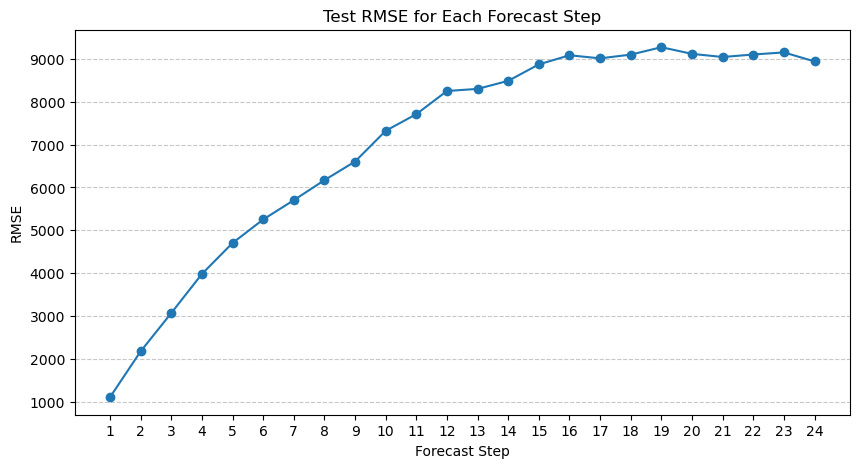

In [26]:
# Compute RMSE for each forecast step
rmses_per_step = []
for h in range(FORECAST_HORIZON):
    true_h = y_test_np[:, h]
    pred_h = predicted_means_test[:, h]
    rmse_h = root_mean_squared_error(true_h, pred_h)
    rmses_per_step.append(rmse_h)
    # print(f"Test RMSE for step {h+1}: {rmse_h:.3f}")

print(f"Average Test RMSE across horizon: {np.mean(rmses_per_step):.3f}")

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, FORECAST_HORIZON + 1), rmses_per_step, marker="o")
plt.xticks(np.arange(1, FORECAST_HORIZON + 1))
plt.xlabel("Forecast Step")
plt.ylabel("RMSE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.title("Test RMSE for Each Forecast Step")
plt.show()


The following boxplot shows the CRPS for each Forecast Horizon $h$ from 1 to 24 hours over the entire test set. The CRPS is a proper scoring rule that measures the sharpness and calibration of probabilistic forecasts. It takes into account both the mean and the variance of the predictions, making it a suitable metric for evaluating Gaussian Process models.

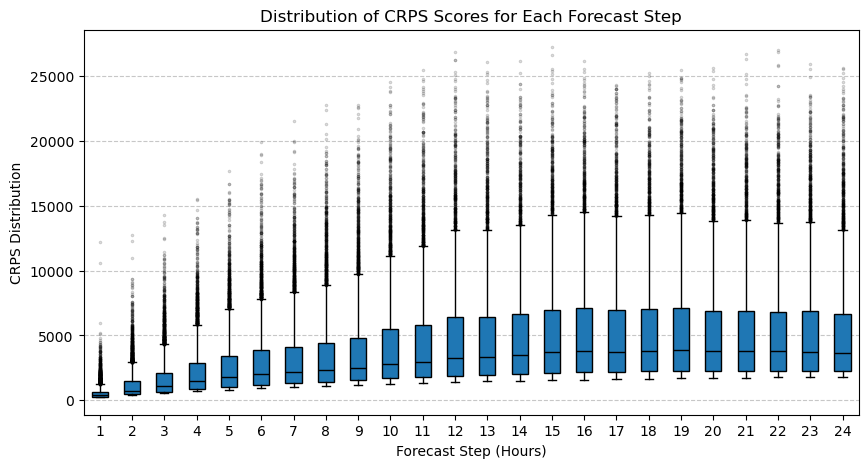

In [27]:
# Compute CRPS for each forecast step
crps_per_step = []
all_crps_samples_per_horizon = []

for h in range(FORECAST_HORIZON):
    true_h = y_test_np[:, h]
    pred_mean_h = predicted_means_test[:, h]
    pred_var_h = predicted_vars_test[:, h]
    
    pred_std_h = np.sqrt(pred_var_h)

    # Compute CRPS
    crps_samples_h = ps.crps_gaussian(
        x=true_h,
        mu=pred_mean_h,
        sig=pred_std_h
    )
    all_crps_samples_per_horizon.append(crps_samples_h)
    
    # Average CRPS for this forecast step
    crps_h = np.mean(crps_samples_h)
    crps_per_step.append(crps_h)

plt.figure(figsize=(10, 5))
horizon_labels = [str(i + 1) for i in range(FORECAST_HORIZON)]
plt.boxplot(
    all_crps_samples_per_horizon,
    tick_labels=horizon_labels,
    patch_artist=True,
    medianprops=dict(color="black"),
    flierprops=dict(marker=".", alpha=0.2, markersize=3),
)
plt.xlabel("Forecast Step (Hours)")
plt.ylabel("CRPS Distribution")
plt.title("Distribution of CRPS Scores for Each Forecast Step")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


**Visualize the Predictions of the SVGP Models**

1. Find the test samples with the lowest and highest RMSE averaged over all forecast horizons.
2. Visualize the predictions of the SVGP models for these 24 hour forecasts.

In [28]:
N_BEST_SAMPLES = 1

sample_rmse_with_idx = []
for idx in range(len(y_test_np)):
    true = y_test_np[idx]
    pred = predicted_means_test[idx]
    rmse = root_mean_squared_error(true, pred)
    sample_rmse_with_idx.append((idx, rmse))
    
# Calculate the average RMSE from the rmse values
rmse_values = [x[1] for x in sample_rmse_with_idx]
print(f"Average RMSE for all samples: {np.mean(rmse_values):.3f}")

# Sort by RMSE value
sample_rmse_with_idx.sort(key=lambda x: x[1])
best_indices = [x[0] for x in sample_rmse_with_idx[:N_BEST_SAMPLES]]
worst_indices = [x[0] for x in sample_rmse_with_idx[-N_BEST_SAMPLES:]]
print(f"Best indices: {best_indices}")
print(f"Worst indices: {worst_indices}")
indices = best_indices + worst_indices

Average RMSE for all samples: 6507.381
Best indices: [5686]
Worst indices: [724]


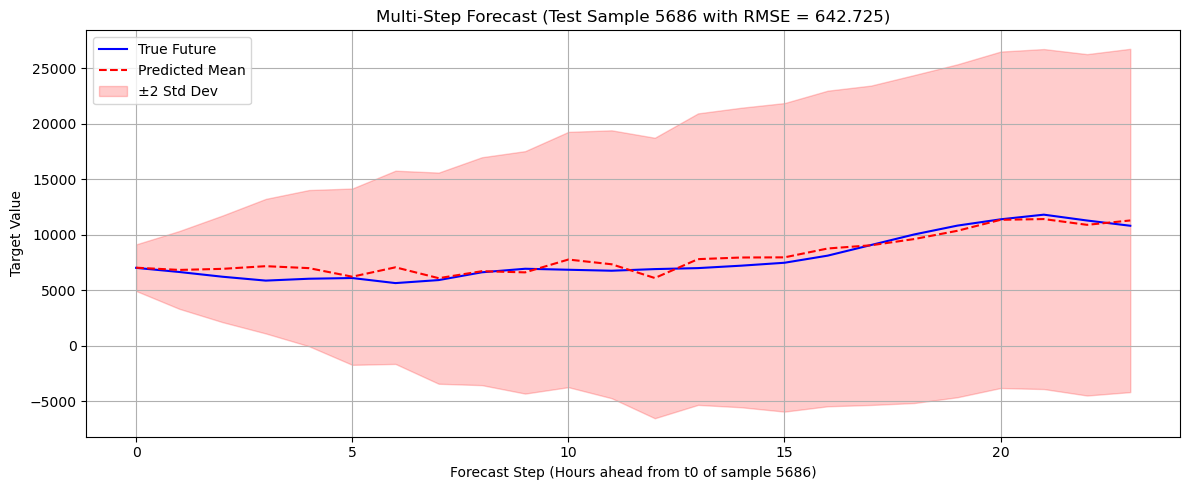

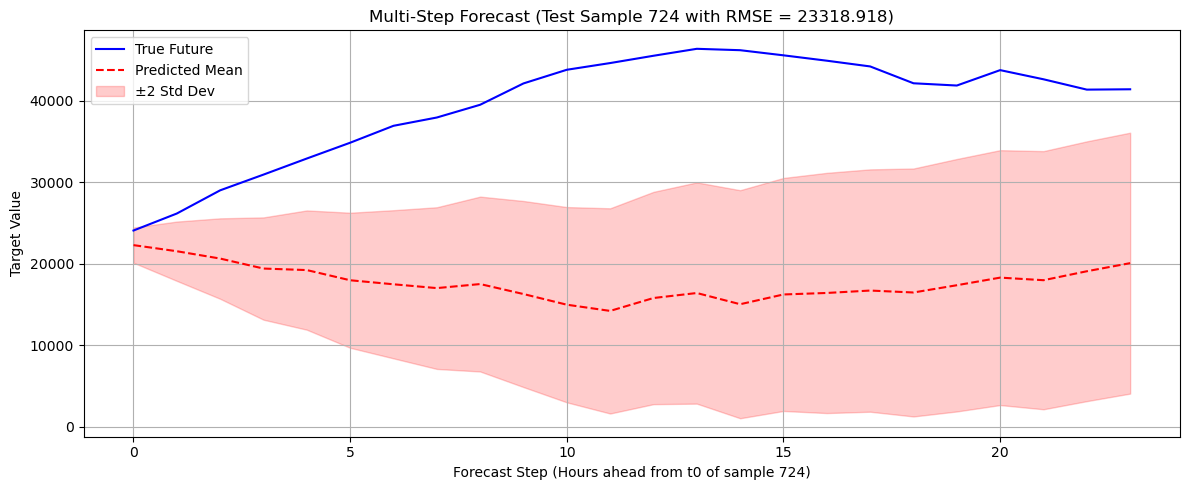

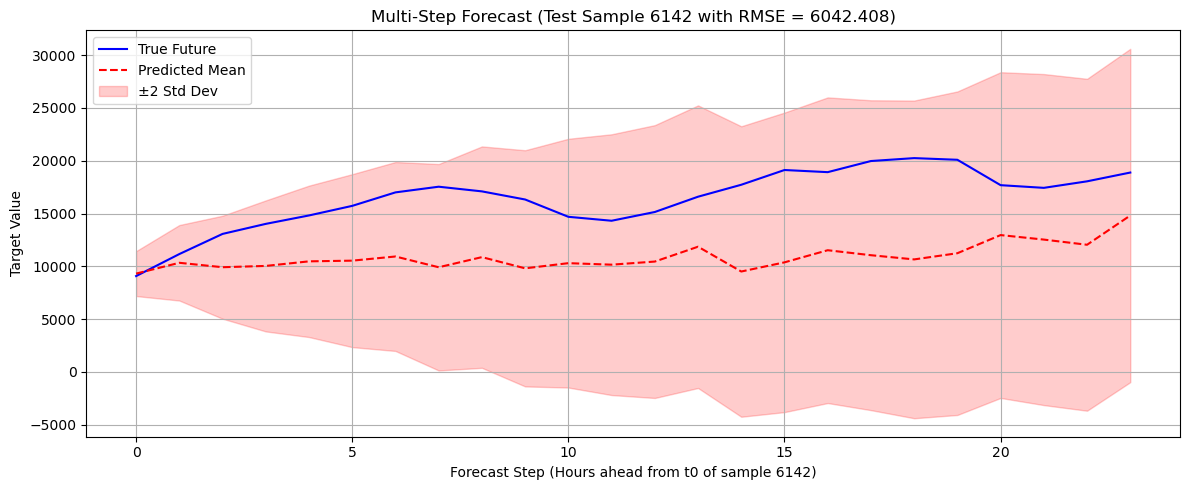

In [29]:
RANDOM_INDICES = True
N_RANDOM_SAMPLES = 1

if RANDOM_INDICES:
    np.random.seed(42)
    random_indices = np.random.choice(len(y_test_np), size=N_RANDOM_SAMPLES, replace=False)
    indices.extend(random_indices.tolist())

for i in indices:
    plt.figure(figsize=(12, 5))

    # Define the x-axis for the forecast horizon
    forecast_steps_axis = np.arange(FORECAST_HORIZON)

    # True future values for this sequence
    true_future_sequence = y_test_np[i, :]

    # Predicted future values for this sequence
    predicted_future_sequence = predicted_means_test[i, :]
    predicted_future_vars = predicted_vars_test[i, :]

    plt.plot(
        forecast_steps_axis, true_future_sequence, "b-", label="True Future"
    )
    plt.plot(
        forecast_steps_axis, predicted_future_sequence, "r--", label="Predicted Mean"
    )

    upper_bound = predicted_future_sequence + 2 * np.sqrt(predicted_future_vars)
    lower_bound = predicted_future_sequence - 2 * np.sqrt(predicted_future_vars)
    plt.fill_between(
        forecast_steps_axis,
        lower_bound,
        upper_bound,
        color="red",
        alpha=0.2,
        label="±2 Std Dev",
    )

    plt.title(f"Multi-Step Forecast (Test Sample {i} with RMSE = {rmse_values[i]:.3f})")
    plt.xlabel(f"Forecast Step (Hours ahead from t0 of sample {i})")
    plt.ylabel("Target Value")
    # plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Visualize the Forecasts for the entire test set**

Since at each point in time we have 24 forecasts, we have a lot of overlapping predictions. I decided to to plot each day as non overlapping segments. This allows us to visualize the forecasts for the entire test set without cluttering the plot.

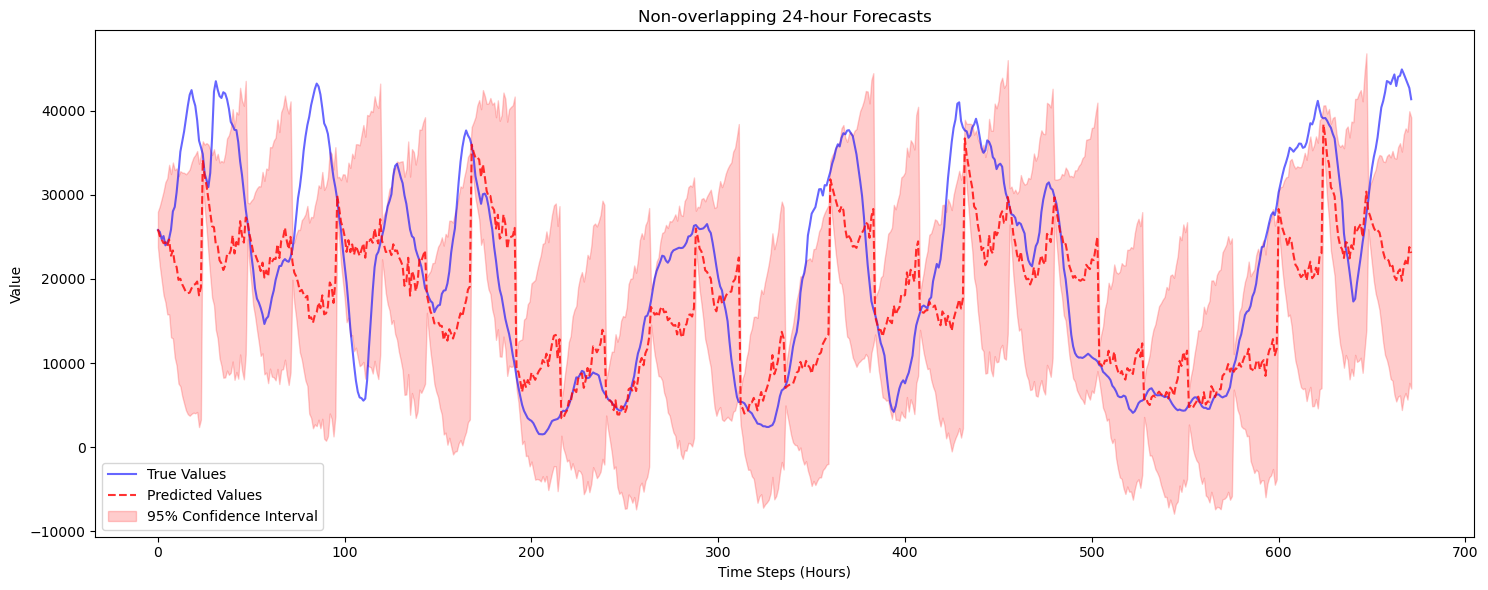

In [30]:
# ---------------------------------------
# 2. Plot along the entire test set
# ---------------------------------------
n_hours = 24 * 7 * 4 # Plot the first 7 days of the test set

# Calculate how many non-overlapping 24-hour segments we can have
number_non_overlapping_test_samples = len(y_test) // FORECAST_HORIZON

# Create time axis for the entire plot
time_axis = np.arange(number_non_overlapping_test_samples * FORECAST_HORIZON)

plt.figure(figsize=(15, 6))

# Extract actual values for the same time points we'll be forecasting
true_values = []
predicted_values = []
confidence_lower = []
confidence_upper = []

# For each non-overlapping segment
for i in range(number_non_overlapping_test_samples):
    # Get the index in the test data
    idx = i * FORECAST_HORIZON

    # Extract true values for this segment
    segment_true = y_test_np[idx]
    true_values.extend(segment_true)

    # Extract predictions for this segment
    segment_predicted = predicted_means_test[idx]
    predicted_values.extend(segment_predicted)

    # Calculate confidence intervals
    segment_vars = predicted_vars_test[idx]
    segment_lower = segment_predicted - 2 * np.sqrt(segment_vars)
    segment_upper = segment_predicted + 2 * np.sqrt(segment_vars)
    confidence_lower.extend(segment_lower)
    confidence_upper.extend(segment_upper)

# Convert to numpy arrays
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)
confidence_lower = np.array(confidence_lower)
confidence_upper = np.array(confidence_upper)

# Plot true values
plt.plot(time_axis[:n_hours], true_values[:n_hours], "b-", label="True Values", alpha=0.6)

# Plot predicted values
plt.plot(time_axis[:n_hours], predicted_values[:n_hours], "r--", label="Predicted Values", alpha=0.8)

# Plot confidence intervals
plt.fill_between(
    time_axis[:n_hours],
    confidence_lower[:n_hours],
    confidence_upper[:n_hours],
    color="red",
    alpha=0.2,
    label="95% Confidence Interval",
)

# Add vertical lines to separate the 24-hour segments
# for i in range(1, number_non_overlapping_test_samples):
#     plt.axvline(x=i * FORECAST_HORIZON, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Time Steps (Hours)")
plt.ylabel("Value")
plt.title("Non-overlapping 24-hour Forecasts")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# plot single horizon for entire test set
horizon = 0